# IMPORT LIBS

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# IMPORT DATA

In [2]:
data = pd.read_csv("./mpg.csv")

# TREAT NaNs 

6 horsepower values are empty

In [3]:
data[data.isna().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


#### Let's build a **predictor** to fill those values (I have time)

Text(0.5, 1.0, 'Horsepower based on displacement')

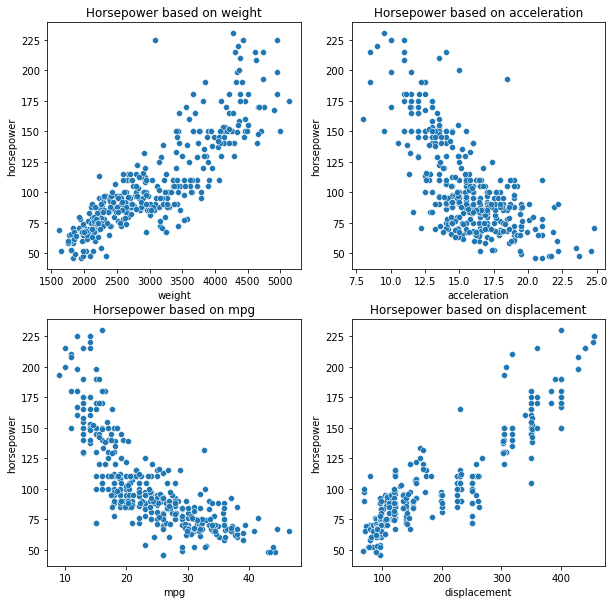

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

sns.scatterplot(data=data, x="weight", y="horsepower", ax=ax[0,0])
sns.scatterplot(data=data, x="acceleration", y="horsepower", ax=ax[0,1])
sns.scatterplot(data=data, x="mpg", y="horsepower", ax=ax[1,0])
sns.scatterplot(data=data, x="displacement", y="horsepower", ax=ax[1,1])

ax[0,0].set_title("Horsepower based on weight")
ax[0,1].set_title("Horsepower based on acceleration")
ax[1,0].set_title("Horsepower based on mpg")
ax[1,1].set_title("Horsepower based on displacement")


There seems to be :

* a linear relationship between horsepower and displacement / weight
* a polynomial relationship between horsepower and mpg / acceleration

Besides there also seems to be a strong correlation between horsepower and number of cylinders :

In [5]:
# Square data to fit polynomial regression
data["mpg²"] = data["mpg"].apply(lambda val: val**2)
data["acceleration²"] = data["acceleration"].apply(lambda val: val**2)

data.corr()["horsepower"]

mpg             -0.778427
cylinders        0.842983
displacement     0.897257
horsepower       1.000000
weight           0.864538
acceleration    -0.689196
model_year      -0.416361
mpg²            -0.709523
acceleration²   -0.646302
Name: horsepower, dtype: float64

[Text(0.5, 1.0, 'Horsepower based on cylinders')]

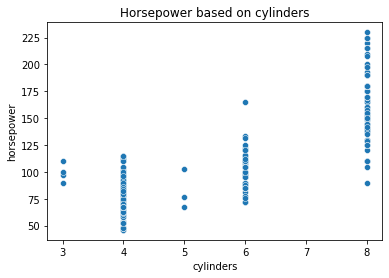

In [6]:
sns.scatterplot(data=data, y="horsepower", x="cylinders").set(title="Horsepower based on cylinders")

# Build a predictor to fill NaNs

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [8]:
train, test = train_test_split(data.dropna(), test_size = 0.2, random_state = 42)

In [9]:
model = LinearRegression().fit(
    train[["cylinders", "mpg", "displacement", "acceleration", "weight", "acceleration²", "mpg²"]], 
    train["horsepower"]
)

In [10]:
test["predictions"] = model.predict(
    test[["cylinders", "mpg", "displacement", "acceleration", "weight", "acceleration²", "mpg²"]]
)

r2 = r2_score(test["horsepower"], test["predictions"])

print(f"R² : {r2}")

R² : 0.910432740539331


R² 0.91 is pretty good.
Also, adding squared mpg and acceleration for polynomial regression improves R² by 3 points

Let's visualize originals vs predictions on the testing set :

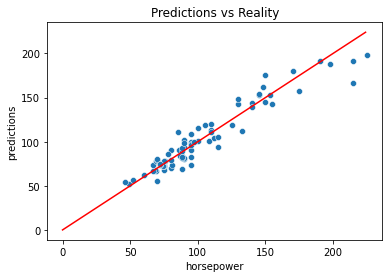

In [11]:
fig, ax = plt.subplots()
horsepower_range = range(max(test["horsepower"].astype("int")))

sns.scatterplot(data=test, x="horsepower", y="predictions", ax=ax).set(title="Predictions vs Reality")
ax.plot(horsepower_range, horsepower_range, color="red")

The predictor is good enough, let's use it to fill the NaNs from the horsepower varialbe

In [12]:
data_NaNs = data[data.isna().any(axis=1)]
data_no_NaNs = data[data["horsepower"].notnull()]

data_NaNs["horsepower"] = model.predict(
    data_NaNs[["cylinders", "mpg", "displacement", "acceleration", "weight", "acceleration²", "mpg²"]]
)

data = pd.concat([data_no_NaNs, data_NaNs])
data.info()

# No more NaNs !!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 374
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mpg            398 non-null    float64
 1   cylinders      398 non-null    int64  
 2   displacement   398 non-null    float64
 3   horsepower     398 non-null    float64
 4   weight         398 non-null    int64  
 5   acceleration   398 non-null    float64
 6   model_year     398 non-null    int64  
 7   origin         398 non-null    object 
 8   name           398 non-null    object 
 9   mpg²           398 non-null    float64
 10  acceleration²  398 non-null    float64
dtypes: float64(6), int64(3), object(2)
memory usage: 37.3+ KB


In [13]:
data.to_csv("mpg_filled.csv")

# Plot cylinder counts

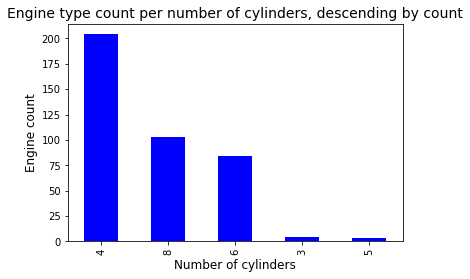

In [14]:
# Sorted by engine count per cylinder
fig, ax = plt.subplots()

data["cylinders"].value_counts().sort_values(ascending=False).plot(kind="bar", color="blue").set(
    title = "Engine type count per number of cylinders, descending by count",
    xlabel = "Number of cylinders",
    ylabel = "Engine count"
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14) if item == ax.title else item.set_fontsize(12)

fig.savefig("barplot1.png")

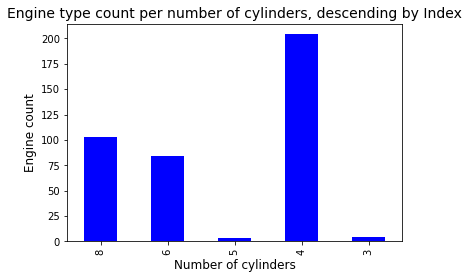

In [15]:
# Sorted by index
fig, ax = plt.subplots()

data["cylinders"].value_counts().sort_index(ascending=False).plot(kind="bar", color="blue").set(
    title = "Engine type count per number of cylinders, descending by Index",
    xlabel = "Number of cylinders",
    ylabel = "Engine count"
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14) if item == ax.title else item.set_fontsize(12)

fig.savefig("barplot2.png")

# MPG Histograms

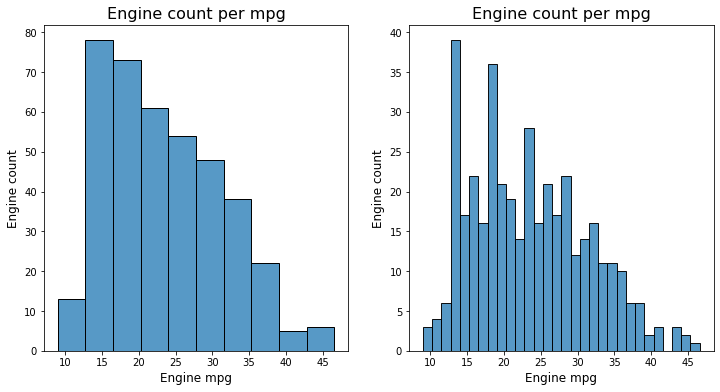

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.histplot(data=data, x="mpg", bins=10, ax=ax[0], edgecolor = "black").set(
    title = "Engine count per mpg",
    xlabel = "Engine mpg",
    ylabel = "Engine count"
)
sns.histplot(data=data, x="mpg", bins=30, ax=ax[1], edgecolor = "black").set(
    title = "Engine count per mpg",
    xlabel = "Engine mpg",
    ylabel = "Engine count"
)

for axis in ax: 
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(16) if item == axis.title else item.set_fontsize(12)

fig.savefig("./histplot.png")
    

# MPG vs Horsepower scatterplot

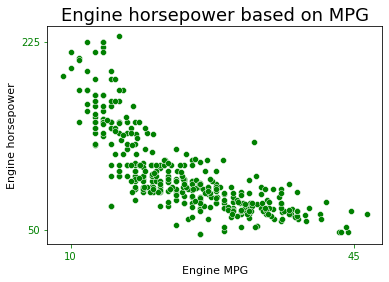

In [17]:
fig, ax = plt.subplots()

sns.scatterplot(data=data, x="mpg", y="horsepower", ax=ax, color="green").set(
    title = "Engine horsepower based on MPG",
    xlabel = "Engine MPG",
    ylabel= "Engine horsepower"
)

ax.xaxis.set_ticks([10,45])
ax.yaxis.set_ticks([50,225])
ax.tick_params(colors='green', which='both')
ax.title.set_fontsize(18)
ax.xaxis.label.set_fontsize(11)
ax.yaxis.label.set_fontsize(11)

fig.savefig("./scatterplot.png")

# Boxplot of MPG based on cylinders

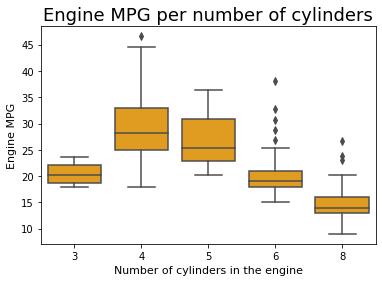

In [18]:
fig, ax = plt.subplots()

sns.boxplot(data=data, x="cylinders", y="mpg", color="orange").set(
    title = "Engine MPG per number of cylinders",
    xlabel = "Number of cylinders in the engine",
    ylabel = "Engine MPG"
)

ax.title.set_fontsize(18)
ax.xaxis.label.set_fontsize(11)
ax.yaxis.label.set_fontsize(11)

fig.savefig("./boxplot.png")